### Importing statements


In [11]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer

import joblib
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout,Input, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import json
from sklearn.model_selection import RandomizedSearchCV
import scipy
import json
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Input, Concatenate, LSTM


## Data Loading

Loaded the save data from Feature Engineering

In [2]:
# Load the CSV file into a DataFrame
data = pd.read_csv('/content/drive/MyDrive/Relevant_health_data.csv')

# Display the first few rows of the DataFrame
data.head()

,index,Timestamp,Subreddit,Type,Post_id,Title,Author,Text,Score,Total_comments,month,hour,day_of_week,Sentiment,Title_word_count,Text_word_count,Category,Processed_Title,Processed_Text
0,0,2018-05-28 19:41:32,mentalhealth,Comment,8msp9v,Mental Health Awareness Month: I have schizoaf...,Candle1nTh3Dark,"Thank you for posting this, I've failed univer...",141.0,0.0,5,19,Monday,negative,48,20,MH_Improvement,mental health awareness month schizoaffective ...,thank posting failed university 3 time due hos...
1,1,2018-05-28 19:53:47,mentalhealth,Comment,8msp9v,Mental Health Awareness Month: I have schizoaf...,sciencelove1994,I have schizoaffective mixed episode type. I a...,61.0,0.0,5,19,Monday,positive,48,33,MH_Improvement,mental health awareness month schizoaffective ...,schizoaffective mixed episode type junior ivy ...
2,2,2018-05-28 20:04:29,mentalhealth,Comment,8msp9v,Mental Health Awareness Month: I have schizoaf...,Unknown,As someone who is struggling with mental illne...,36.0,0.0,5,20,Monday,negative,48,49,MH_Improvement,mental health awareness month schizoaffective ...,someone struggling mental illness currently co...
3,3,2018-05-28 20:00:07,mentalhealth,Comment,8msp9v,Mental Health Awareness Month: I have schizoaf...,swild89,I’m heading back now at 28! Thanks for the ins...,28.0,0.0,5,20,Monday,positive,48,11,MH_Improvement,mental health awareness month schizoaffective ...,heading back 28 thanks inspiration
4,4,2018-05-28 21:21:11,mentalhealth,Comment,8msp9v,Mental Health Awareness Month: I have schizoaf...,BoozeMeUpScotty,Yayyyy!!! Good for you! This is my favorite ki...,11.0,0.0,5,21,Monday,positive,48,499,MH_Improvement,mental health awareness month schizoaffective ...,yayyyy good favorite kind post see anywhere wo...


> The above data has the preprocessed title, text and category

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838721 entries, 0 to 838720
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   index             838721 non-null  int64  
 1   Timestamp         838721 non-null  object 
 2   Subreddit         838721 non-null  object 
 3   Type              838721 non-null  object 
 4   Post_id           838721 non-null  object 
 5   Title             838721 non-null  object 
 6   Author            838721 non-null  object 
 7   Text              838721 non-null  object 
 8   Score             838721 non-null  float64
 9   Total_comments    838721 non-null  float64
 10  month             838721 non-null  int64  
 11  hour              838721 non-null  int64  
 12  day_of_week       838721 non-null  object 
 13  Sentiment         838721 non-null  object 
 14  Title_word_count  838721 non-null  int64  
 15  Text_word_count   838721 non-null  int64  
 16  Category          83

In [4]:
data.isnull().sum()

,0
index,0
Timestamp,0
Subreddit,0
Type,0
Post_id,0
Title,0
Author,0
Text,0
Score,0
Total_comments,0


In [5]:
data = data.dropna(subset=['Processed_Title', 'Processed_Text']).reset_index(drop=True)


In [6]:
data.isnull().sum()

,0
index,0
Timestamp,0
Subreddit,0
Type,0
Post_id,0
Title,0
Author,0
Text,0
Score,0
Total_comments,0


## Model Training

#### Data Preparation

> Considered the below relevant columns for X and target value for y -I have taken Category

In [12]:
relevant_columns = [
    'Subreddit',  'Title_word_count', 'Text_word_count',
    'Score', 'Total_comments','Sentiment' ,'Processed_Title', 'Processed_Text'
]

## Label Encoding and Text vectorization

In [13]:
# Selecting relevant data for X
X = data[relevant_columns]
y = data['Category']

# Text vectorization for 'Processed_Title' and 'Processed_Text'
vectorizer_title = TfidfVectorizer(max_features=1000)
vectorizer_text = TfidfVectorizer(max_features=5000)


# Label encoding for categorical variables
label_encoder = LabelEncoder()
X['Subreddit'] = label_encoder.fit_transform(X['Subreddit'])
X['Sentiment'] = label_encoder.fit_transform(X['Sentiment'])

# Standardizing numerical columns
scaler = StandardScaler()

In [14]:


# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=4)

In [15]:

# Vectorizing text features for training data
X_train_title_tfidf = vectorizer_title.fit_transform(X_train['Processed_Title'])
X_train_text_tfidf = vectorizer_text.fit_transform(X_train['Processed_Text'])

X_test_title_tfidf = vectorizer_title.transform(X_test['Processed_Title'])
X_test_text_tfidf = vectorizer_text.transform(X_test['Processed_Text'])

# Dropping the original text columns (since they are now vectorized)
X_train = X_train.drop(columns=['Processed_Title', 'Processed_Text'])
X_test = X_test.drop(columns=['Processed_Title', 'Processed_Text'])

In [16]:

# Scaling numerical columns
X_train[['Title_word_count', 'Text_word_count', 'Score', 'Total_comments']] = scaler.fit_transform(
    X_train[['Title_word_count', 'Text_word_count', 'Score', 'Total_comments']]
)
X_test[['Title_word_count', 'Text_word_count', 'Score', 'Total_comments']] = scaler.transform(
    X_test[['Title_word_count', 'Text_word_count', 'Score', 'Total_comments']]
)

In [17]:
# Concatenating vectorized text data with the other features
X_train_combined = scipy.sparse.hstack([X_train, X_train_title_tfidf, X_train_text_tfidf])
X_test_combined = scipy.sparse.hstack([X_test, X_test_title_tfidf, X_test_text_tfidf])

In [18]:


# Directory to save the models
model_dir = './content/drive/MyDrive/saved_models'
os.makedirs(model_dir, exist_ok=True)


### Traditional machine learning models

In [19]:
# Function to train, save, and evaluate model with cross-validation, learning curves, and confusion matrix
def train_save_evaluate_model_with_learning_curves(model, model_name, X_train_combined, y_train, X_test_combined, y_test, cv=5):
    # Cross-validation
    print(f"Training {model_name} with cross-validation...")
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=4)
    print(f"{model_name} cross-validation initialized.")
    # Train the model with cross-validation and calculate learning curves
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train_combined, y_train, cv=skf, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )
    print(f"{model_name} trained with cross-validation.")
    # Calculate mean and standard deviation of training and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    print(f"{model_name} learning curves calculated.")
    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.title(f"Learning Curves for {model_name}")
    plt.show()

    # Train the model on the full training set
    model.fit(X_train_combined, y_train)
    print(f"{model_name} trained on the full training set.")
    # Set the Google Drive directory path
    drive_folder = '/content/drive/MyDrive/models'
    os.makedirs(drive_folder, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, f'{model_name}.joblib')
    joblib.dump(model, model_path)
    print(f"{model_name} saved to {model_path}")

    # Evaluate the model on the test set
    y_pred = model.predict(X_test_combined)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Test Accuracy: {accuracy:.2f}")
    print(f"Classification Report for {model_name}:\n", classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()


In [20]:
# Function to save and evaluate model
def train_save_evaluate_model(model, model_name):
    # Train the model
    model.fit(X_train_combined, y_train)

    # Save the trained model
    model_path = os.path.join(model_dir, f'{model_name}.joblib')
    joblib.dump(model, model_path)
    print(f"{model_name} saved to {model_path}")

    # Evaluate the model
    y_pred = model.predict(X_test_combined)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.2f}")
    print(f"Classification Report for {model_name}:\n", classification_report(y_test, y_pred))


## Logistic Regression


In [ ]:
# # Logistic Regression
logistic_model = LogisticRegression(max_iter=1000)
train_save_evaluate_model(logistic_model, 'logistic_regression')



logistic_regression saved to ./content/drive/MyDrive/saved_models/logistic_regression.joblib
logistic_regression Accuracy: 0.89
Classification Report for logistic_regression:
                 precision    recall  f1-score   support

  MH_Disorders       0.91      0.93      0.92    208770
   MH_Distress       0.82      0.57      0.67     16068
MH_Improvement       0.85      0.85      0.85    103066
         Other       0.84      0.38      0.52      2368

      accuracy                           0.89    330272
     macro avg       0.85      0.68      0.74    330272
  weighted avg       0.88      0.89      0.88    330272



- The model achieves an accuracy of 0.89, which indicates strong overall performance. This is slightly lower than the Random Forest model's accuracy (0.99), but still fairly high.
- The model performs very well for the "MH_Disorders" class, with high precision and recall. This indicates that instances of this class are well-detected with minimal misclassification.
- The model achieves balanced precision and recall for "MH_Improvement," with an F1-score of 0.85. This consistent performance suggests that the model reliably classifies instances in this category.


Training logistic_regression with cross-validation...
logistic_regression trained with cross-validation.
logistic_regression learning curves calculated.


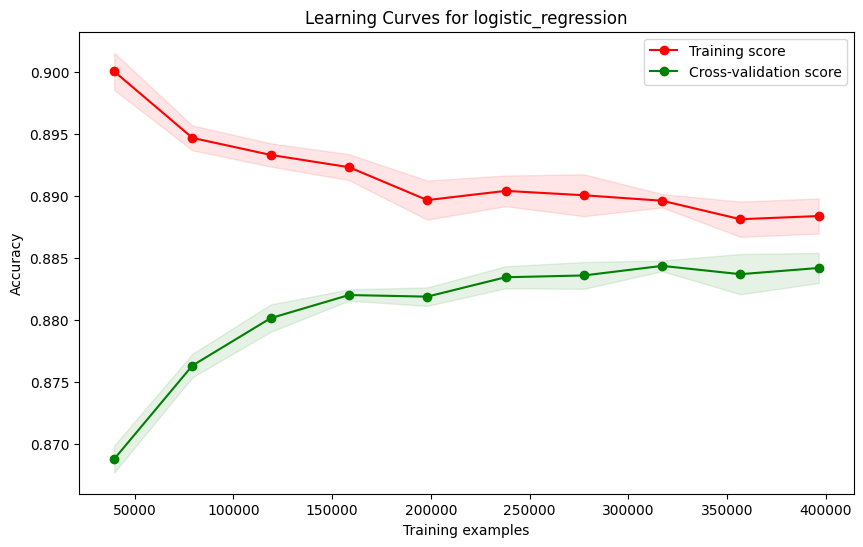

logistic_regression trained on the full training set.
logistic_regression saved to ./content/drive/MyDrive/saved_models/logistic_regression.joblib
logistic_regression Test Accuracy: 0.89
Classification Report for logistic_regression:
                 precision    recall  f1-score   support

  MH_Disorders       0.90      0.93      0.92    208770
   MH_Distress       0.82      0.57      0.67     16068
MH_Improvement       0.85      0.85      0.85    103066
         Other       0.85      0.41      0.55      2368

      accuracy                           0.89    330272
     macro avg       0.86      0.69      0.75    330272
  weighted avg       0.88      0.89      0.88    330272



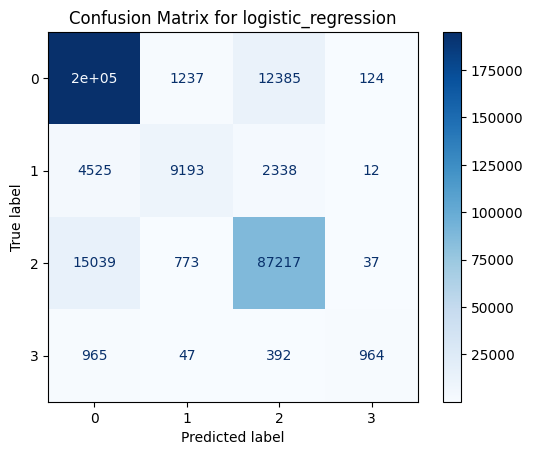

In [ ]:

# Logistic Regression with learning curves, validation, and confusion matrix
logistic_model = LogisticRegression(max_iter=1000)
train_save_evaluate_model_with_learning_curves(logistic_model, 'logistic_regression', X_train_combined, y_train, X_test_combined, y_test, cv=5)


*  The training accuracy starts high and gradually decreases, stabilizing around 89%. This indicates that the model fits well to the training data without overfitting, but its initial high accuracy suggests that it may have started with some overfitting at smaller training sizes.
* The cross-validation accuracy steadily improves as the training data size increases, eventually stabilizing around 88%.
* The gap between the training and cross-validation accuracy suggests some room for improvement, likely due to complexity in the data that the logistic regression model struggles to fully capture.


### Confusion Matrix Analysis
* MH_Disorders (Class 0): The model performs well in predicting MH_Disorders, with a high count of true positives and low false negatives and false positives. This category has the highest support and seems to be well learned by the model.
* MH_Distress (Class 1): The performance is weaker for MH_Distress, with a significant number of false negatives. Many instances from MH_Distress are misclassified as MH_Disorders or MH_Improvement, indicating overlap in characteristics between these categories.
* MH_Improvement (Class 2): The model performs reasonably well on MH_Improvement, with good recall and precision.
* Other (Class 3): The model struggles with this class, as seen in both the confusion matrix and the low recall score. Instances from the "Other" category are often misclassified into other classes.

### Test Accuracy
The overall test accuracy is 89%, which is a strong result, but the confusion matrix and class-specific performance metrics show that this high accuracy is is for classifying the more frequent categories (MH_Disorders) correctly.



> The logistic regression model shows good accuracy and generalization but exhibits some limitations in handling the less common and more nuanced classes like MH_Distress and Other. This is likely due to the overlap in language and themes across mental health discussions, making it challenging for the model to distinguish between similar categories.


# Random Forest Classifier

In [ ]:
# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
train_save_evaluate_model(model=rf_model, model_name='random_forest')



random_forest saved to ./content/drive/MyDrive/saved_models/random_forest.joblib
random_forest Accuracy: 0.99
Classification Report for random_forest:
                 precision    recall  f1-score   support

  MH_Disorders       0.99      1.00      0.99    208770
   MH_Distress       1.00      0.87      0.93     16068
MH_Improvement       0.99      0.99      0.99    103066
         Other       1.00      0.79      0.88      2368

      accuracy                           0.99    330272
     macro avg       0.99      0.91      0.95    330272
  weighted avg       0.99      0.99      0.99    330272



- The model achieves an  accuracy of 0.99 on the dataset, which suggests it performs very well on average across all classes.
- The Random Forest model performs very well overall, with high precision and recall, especially for the major classes "MH_Disorders" and "MH_Improvement."
- Recall improvement is needed for the "MH_Distress" and "Other" classes.
- The "Other" class has the lowest recall at 0.79, shows that some instances in this class are being misclassified as other categories. It is diue to small support (2,368 instances), the model had fewer examples to learn from.

# Deep Learning Models

### Variable and Data Preparation for CNN Models

In [ ]:
# Parameters
max_vocab_size = 20000
max_sequence_length = 100
embedding_dim = 50

In [ ]:
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(data['Processed_Text'].values)
X_text = tokenizer.texts_to_sequences(data['Processed_Text'].values)
X_text = pad_sequences(X_text, maxlen=max_sequence_length)


In [ ]:
# relevant columns and separate categorical from numerical columns
relevant_columns = ['Title_word_count', 'Text_word_count', 'Score', 'Total_comments', 'Sentiment']
numerical_columns = ['Title_word_count', 'Text_word_count', 'Score', 'Total_comments']
categorical_columns = ['Sentiment']

# Scaling the numerical features
X_numerical = data[numerical_columns]
scaler = StandardScaler()
X_numerical = scaler.fit_transform(X_numerical)

# Encoding the categorical features
label_encoder = LabelEncoder()
X_categorical = label_encoder.fit_transform(data['Sentiment'])

# Combining numerical and categorical features
X_additional = np.concatenate([X_numerical, X_categorical.reshape(-1, 1)], axis=1)



In [ ]:

# Concatenate text and additional features along the second axis
X_combined = np.concatenate([X_text, X_additional], axis=1)

# Prepare labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['Category'].values)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)


## Hybrid CNN
> Hybrid CNN  combines a CNN-based text-processing pipeline (embedding, Conv1D, pooling) with an additional input layer for non-text features, which are then concatenated and passed into a fully connected layer.

This is a multimodal neural network model using the Keras API in TensorFlow, combining text data with additional numeric or categorical features for a multi-class classification task.




In [ ]:

# Define the inputs for the model -- Accepts text data sequences, processed through an embedding and convolutional layer.
text_input = Input(shape=(max_sequence_length,))
additional_input = Input(shape=(X_additional.shape[1],)) # Accepts text data sequences, processed through an embedding and convolutional layer.

# Text processing layers (embedding and convolution for text data)
embedding_layer = Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)(text_input) # Converts words into dense vectors of fixed size.
conv_layer = Conv1D(128, 5, activation='relu')(embedding_layer) #  Applies a 1D convolution over the text embeddings, extracting features.

pooling_layer = GlobalMaxPooling1D()(conv_layer) # Reduces the output from the convolution layer, capturing the most salient features.

# Concatenate text and additional inputs
concatenated = Concatenate()([pooling_layer, additional_input])

# Fully connected layers
dense_layer = Dense(32, activation='relu')(concatenated) # Adds a fully connected layer with 32 units for learning more complex patterns.
dropout_layer = Dropout(0.7)(dense_layer) # Applies dropout to prevent overfitting.
output_layer = Dense(4, activation='softmax')(dropout_layer)  #Produces a 4-class softmax output, suitable for a multi-class classification problem.


# Compile the model -- Uses the Adam optimizer and sparse_categorical_crossentropy loss, with accuracy as the evaluation metric.

model = Model(inputs=[text_input, additional_input], outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Model summary
model.summary()




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 50)        │      1,000,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 96, 128)        │         32,128 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 128)            │              0 │ conv1d[0][0]           │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 5)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 133)            │              0 │ global_max_pooling1d[… │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │          4,288 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 4)              │            132 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,036,548 (3.95 MB)

 Trainable params: 1,036,548 (3.95 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Set up checkpointing to save model weights
checkpoint_dir = './content/drive/MyDrive/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "model-{epoch:02d}-{val_accuracy:.2f}.weights.h5")
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      save_weights_only=True,
                                      save_best_only=True,
                                      monitor='val_accuracy',
                                      mode='max',
                                      verbose=1)


# Early stopping to prevent overfitting
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=4,          # Stop after 1 epoch with no improvement
    restore_best_weights=True,  # Restore model weights from the epoch with the best validation loss
    verbose=1
)

# Train the model and save history
history = model.fit(
    [X_train[:, :max_sequence_length], X_train[:, max_sequence_length:]],  # Adjust input data as needed
    y_train,
    epochs=10,
    validation_split=0.2,
    batch_size=32,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

# Save training history
history_path = 'training_history.json'
with open(history_path, 'w') as f:
    json.dump(history.history, f)

print(f"Training history saved to {history_path}")



Epoch 1/10
16514/16514 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6693 - loss: 0.7620
Epoch 1: val_accuracy improved from -inf to 0.71460, saving model to ./content/drive/MyDrive/checkpoints/model-01-0.71.weights.h5
16514/16514 ━━━━━━━━━━━━━━━━━━━━ 423s 26ms/step - accuracy: 0.6693 - loss: 0.7620 - val_accuracy: 0.7146 - val_loss: 0.6558
Epoch 2/10
16512/16514 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7148 - loss: 0.6657
Epoch 2: val_accuracy did not improve from 0.71460
16514/16514 ━━━━━━━━━━━━━━━━━━━━ 442s 26ms/step - accuracy: 0.7148 - loss: 0.6657 - val_accuracy: 0.7146 - val_loss: 0.6498
Epoch 3/10
16513/16514 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7304 - loss: 0.6359
Epoch 3: val_accuracy improved from 0.71460 to 0.71603, saving model to ./content/drive/MyDrive/checkpoints/model-03-0.72.weights.h5
16514/16514 ━━━━━━━━━━━━━━━━━━━━ 438s 25ms/step - accuracy: 0.7304 - loss: 0.6359 - val_accuracy: 0.7160 - val_loss: 0.6507
Epoch 4/10
16512/16514 ━━━━━━━━━━━━━━━━━━

> Early stopping was triggered after epoch 6, restoring the model weights to epoch 2, which had the best validation accuracy of around 71.60%. This is a good decision as the model's performance on validation data deteriorated after epoch 2, further confirming overfitting.

In [ ]:
# # Reload model from checkpoint
# latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
# if latest_checkpoint:
#     model.load_weights(latest_checkpoint)
#     print(f"Loaded model from {latest_checkpoint}")

# # Continue training if needed
# model.fit(
#     X_train, y_train,
#     epochs=5,  # Add more epochs as needed
#     validation_split=0.2,
#     batch_size=32
# )

# Load and plot training history
with open(history_path, 'r') as f:
    saved_history = json.load(f)



In [ ]:
# Split X_test into text and additional features
X_test_text = X_test[:, :max_sequence_length]           # Text input
X_test_additional = X_test[:, max_sequence_length:]     # Additional features input

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate([X_test_text, X_test_additional], y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")


5161/5161 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - accuracy: 0.7151 - loss: 0.6505
Test Accuracy: 0.71


> The final test accuracy is 71.51%, which is close with the best validation accuracy, suggesting that the early-stopped model has generalized reasonably well to unseen data.

In [ ]:
# Print saved history or plot (if you want to visualize training progress)
print("Training and Validation Accuracy:", saved_history.get('accuracy'), saved_history.get('val_accuracy'))


Training and Validation Accuracy: [0.6881565451622009, 0.7140991687774658, 0.7286913394927979, 0.7452439665794373, 0.7611929774284363, 0.7757245302200317] [0.7145993113517761, 0.7145917415618896, 0.716029942035675, 0.7128734588623047, 0.7110189199447632, 0.7070600986480713]


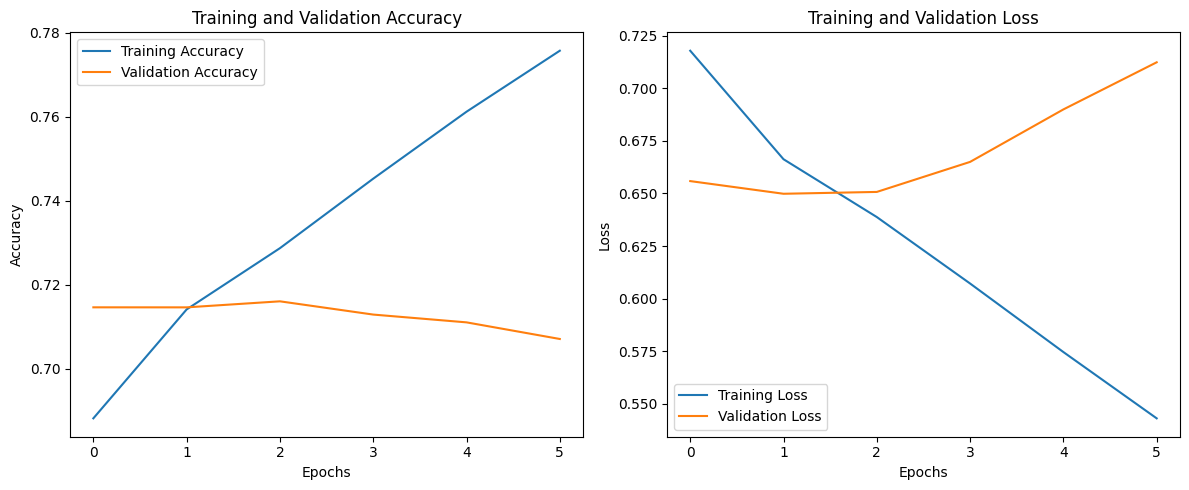

In [ ]:


# Load training history
history_path = 'training_history.json'
with open(history_path, 'r') as f:
    saved_history = json.load(f)

# Extract accuracy and loss data
train_accuracy = saved_history.get('accuracy', [])
val_accuracy = saved_history.get('val_accuracy', [])
train_loss = saved_history.get('loss', [])
val_loss = saved_history.get('val_loss', [])

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()




#### Accuracy:

* There is a steady increase in training accuracy across the epochs, indicating that the model is learning from the training data and improving in performance.
* The validation accuracy initially shows a slight improvement but plateaus early and even begins to decrease.
* This suggests that the model might be starting to overfit, as it performs well on the training data but not as effectively on unseen validation data.

#### Loss:

* The training loss consistently decreases, showing that the model is minimizing the error on the training data.
* The validation loss, on the other hand, does not follow the same trend.
* It decreases slightly at the start but begins to increase in later epochs. This divergence between training and validation loss is a sign of overfitting.

#### Training Accuracy vs. Validation Accuracy:

The training accuracy consistently improves, reaching close to 78%, while the validation accuracy peaks early and then gradually declines. This reinforces the likelihood of overfitting.

#### Training Loss vs. Validation Loss:

* The training loss decreases steadily, indicating effective learning on the training data.
* The validation loss, however, initially drops but then starts to increase after the second epoch, which again suggests overfitting.
* The model is unable to generalize effectively to validation data, as seen by the increase in validation loss and the decrease in validation accuracy.


In [ ]:
# Set up checkpointing to save model weights
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "model1-50-{epoch:02d}-{val_accuracy:.2f}.weights.h5")  # Changed extension to .weights.h5
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      save_weights_only=True,
                                      save_best_only=True,
                                      monitor='val_accuracy',
                                      mode='max',
                                      verbose=1)

# Early stopping to prevent overfitting
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=3,          # Stop after 1 epoch with no improvement
    restore_best_weights=True,  # Restore model weights from the epoch with the best validation loss
    verbose=1
)

# Train the model and save history
history = model.fit(
    [X_train[:, :max_sequence_length], X_train[:, max_sequence_length:]],  # Adjust input data as needed
    y_train,
    epochs=50,
    validation_split=0.2,
    batch_size=32,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

# Save training history
history_path = 'training_history50.json'
with open(history_path, 'w') as f:
    json.dump(history.history, f)

print(f"Training history saved to {history_path}")


Epoch 1/50
16514/16514 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7320 - loss: 0.6310
Epoch 1: val_accuracy improved from -inf to 0.71717, saving model to ./checkpoints/model1-50-01-0.72.weights.h5
16514/16514 ━━━━━━━━━━━━━━━━━━━━ 464s 28ms/step - accuracy: 0.7320 - loss: 0.6310 - val_accuracy: 0.7172 - val_loss: 0.6537
Epoch 2/50
16512/16514 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7487 - loss: 0.6002
Epoch 2: val_accuracy did not improve from 0.71717
16514/16514 ━━━━━━━━━━━━━━━━━━━━ 426s 26ms/step - accuracy: 0.7487 - loss: 0.6002 - val_accuracy: 0.7133 - val_loss: 0.6656
Epoch 3/50
16514/16514 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7654 - loss: 0.5671
Epoch 3: val_accuracy did not improve from 0.71717
16514/16514 ━━━━━━━━━━━━━━━━━━━━ 450s 26ms/step - accuracy: 0.7654 - loss: 0.5671 - val_accuracy: 0.7131 - val_loss: 0.6892
Epoch 4/50
16512/16514 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7819 - loss: 0.5319
Epoch 4: val_accuracy did not improve from 0.71717

>> Early stopping was triggered after the fourth epoch, restoring the model weights to those from the first epoch, where the highest validation accuracy was observed. This suggests that the model achieved its best generalization early in training.

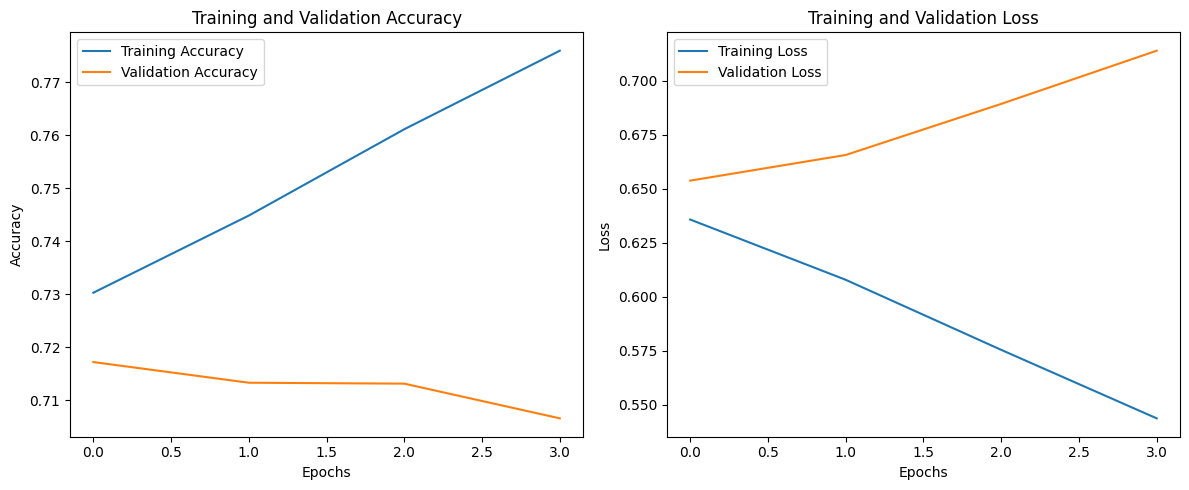

In [ ]:


# Load training history
history_path = 'training_history50.json'
with open(history_path, 'r') as f:
    saved_history = json.load(f)

# Extract accuracy and loss data
train_accuracy = saved_history.get('accuracy', [])
val_accuracy = saved_history.get('val_accuracy', [])
train_loss = saved_history.get('loss', [])
val_loss = saved_history.get('val_loss', [])

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


* Training accuracy steadily improves over the epochs, reaching close to 78% by the fourth epoch, indicating that the model is learning effectively on the training set.
* Validation accuracy peaks in the first epoch at around 71.72% and then declines, indicating early signs of overfitting. This is confirmed by the validation accuracy not improving after the first epoch.

* Training loss consistently decreases, showing that the model is minimizing error on the training data.
* Validation loss starts low but increases from the second epoch onward. This divergence between training and validation loss is a classic sign of overfitting, as the model performs well on the training data but fails to generalize effectively on the validation data.





In [ ]:
# Load and plot training history
with open(history_path, 'r') as f:
    saved_history = json.load(f)

In [ ]:
# Split X_test into text and additional features
X_test_text = X_test[:, :max_sequence_length]           # Text input
X_test_additional = X_test[:, max_sequence_length:]     # Additional features input

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate([X_test_text, X_test_additional], y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

5161/5161 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.7167 - loss: 0.6546
Test Accuracy: 0.72


>> The final test accuracy is around 71.67%, which aligns closely with the validation accuracy at the best epoch, indicating consistency in generalization.

In [ ]:
# Print saved history or plot (if you want to visualize training progress)
print("Training and Validation Accuracy:", saved_history.get('accuracy'), saved_history.get('val_accuracy'))


Training and Validation Accuracy: [0.7302525639533997, 0.7448163032531738, 0.7611078023910522, 0.7759232521057129] [0.7171653509140015, 0.7132670879364014, 0.7130929827690125, 0.706545352935791]


## Kim’s CNN Model

- The model includes multiple convolution layers with different filter sizes (3, 4, and 5), which is a hallmark of Kim's model. This approach allows it to identify various n-gram features from the text data.
- Each convolutional layer is followed by Global Max Pooling, as in Kim’s original model, which selects the most main feature from each feature map.
- This model is hybrid because it incorporates additional non-textual input (using the additional_input layer).This hybrid structure enables the model to learn from both text and non-text data simultaneously.

In [ ]:

# Define inputs for text and additional features
text_input = Input(shape=(max_sequence_length,), name="text_input")
additional_input = Input(shape=(X_additional.shape[1],), name="additional_input")

# Embedding layer
embedding_layer = Embedding(input_dim=max_vocab_size, output_dim=64, input_length=max_sequence_length)(text_input)

# Multiple Conv1D layers with different filter sizes (Kim's model)
conv_3 = Conv1D(64, 3, activation='relu')(embedding_layer)
conv_4 = Conv1D(64, 4, activation='relu')(embedding_layer)
conv_5 = Conv1D(64, 5, activation='relu')(embedding_layer)

# Global Max Pooling for each convolution layer
pool_3 = GlobalMaxPooling1D()(conv_3)
pool_4 = GlobalMaxPooling1D()(conv_4)
pool_5 = GlobalMaxPooling1D()(conv_5)

# Concatenate all pooled features
concatenated = Concatenate()([pool_3, pool_4, pool_5, additional_input])

# Fully connected layers
dense_layer = Dense(32, activation='relu')(concatenated)
dropout_layer = Dropout(0.7)(dense_layer)
output_layer = Dense(4, activation='softmax')(dropout_layer)  # Multi-class classification (4 classes)

# Compile the model with appropriate loss for multi-class classification
model_kim = Model(inputs=[text_input, additional_input], outputs=output_layer)
model_kim.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model_kim.summary()




Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 100, 64)        │      1,280,000 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 98, 64)         │         12,352 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 97, 64)         │         16,448 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 96, 64)         │         20,544 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_1    │ (None, 64)             │              0 │ conv1d_1[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_2    │ (None, 64)             │              0 │ conv1d_2[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_3    │ (None, 64)             │              0 │ conv1d_3[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ additional_input          │ (None, 5)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 197)            │              0 │ global_max_pooling1d_… │
│ (Concatenate)             │                        │                │ global_max_pooling1d_… │
│                           │                        │                │ global_max_pooling1d_… │
│                           │                        │                │ additional_input[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │          6,336 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 4)              │            132 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,335,812 (5.10 MB)

 Trainable params: 1,335,812 (5.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Split X_train and X_test into separate inputs for training and testing
X_train_text = X_train[:, :max_sequence_length]           # Text input
X_train_additional = X_train[:, max_sequence_length:]     # Additional features input

# Set up checkpointing and early stopping
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "modelkim-{epoch:02d}-{val_accuracy:.2f}.weights.h5")
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history_kim = model_kim.fit(
    [X_train_text, X_train_additional],  # Provided text and additional inputs separately
    y_train,
    epochs=50,
    validation_split=0.2,
    batch_size=32,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

# Save the training history
history_path = 'kim_cnn_history.json'
with open(history_path, 'w') as f:
    json.dump(history_kim.history, f)
print(f"Training history saved to {history_path}")

# Prepare test data for evaluation
X_test_text = X_test[:, :max_sequence_length]
X_test_additional = X_test[:, max_sequence_length:]

# Evaluate the model on test data
test_loss, test_accuracy = model_kim.evaluate([X_test_text, X_test_additional], y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")



Epoch 1/50
16513/16514 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6694 - loss: 0.7569
Epoch 1: val_accuracy improved from -inf to 0.71097, saving model to ./checkpoints/modelkim-01-0.71.weights.h5
16514/16514 ━━━━━━━━━━━━━━━━━━━━ 662s 40ms/step - accuracy: 0.6694 - loss: 0.7569 - val_accuracy: 0.7110 - val_loss: 0.6628
Epoch 2/50
16513/16514 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7148 - loss: 0.6630
Epoch 2: val_accuracy improved from 0.71097 to 0.71530, saving model to ./checkpoints/modelkim-02-0.72.weights.h5
16514/16514 ━━━━━━━━━━━━━━━━━━━━ 672s 39ms/step - accuracy: 0.7148 - loss: 0.6630 - val_accuracy: 0.7153 - val_loss: 0.6486
Epoch 3/50
16513/16514 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7299 - loss: 0.6349
Epoch 3: val_accuracy improved from 0.71530 to 0.71730, saving model to ./checkpoints/modelkim-03-0.72.weights.h5
16514/16514 ━━━━━━━━━━━━━━━━━━━━ 688s 40ms/step - accuracy: 0.7299 - loss: 0.6349 - val_accuracy: 0.7173 - val_loss: 0.6526
Epoch 4/50
16514

>>The test accuracy is around 71.44%, which is consistent with the validation accuracy achieved in the early epochs, confirming the model's generalization ability when early-stopping was applied.


>> The best validation accuracy achieved is around 71.73% in the third epoch, and the model saves its weights at this point. This indicates that the best generalization was achieved early in the training, and subsequent epochs did not improve validation performance.

In [ ]:
# Load and plot training history
with open(history_path, 'r') as f:
    saved_history = json.load(f)

In [ ]:
# Print saved history or plot (if you want to visualize training progress)
print("Training and Validation Accuracy:", saved_history.get('accuracy'), saved_history.get('val_accuracy'))

Training and Validation Accuracy: [0.6877023577690125, 0.7134785056114197, 0.7286686301231384, 0.7454445958137512, 0.7624116539955139] [0.7109735012054443, 0.7152957320213318, 0.717301607131958, 0.7146825790405273, 0.7122754454612732]


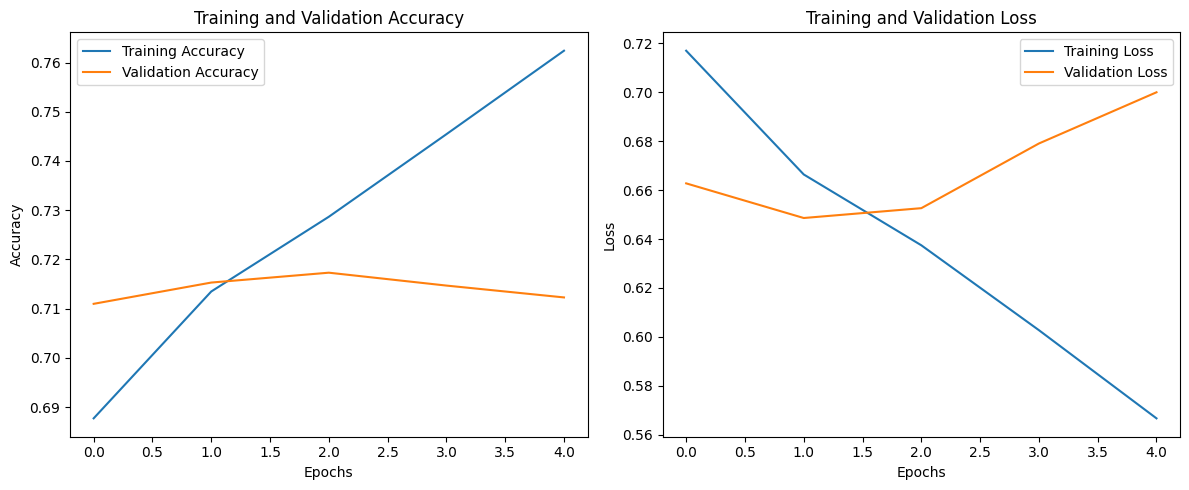

In [ ]:


# Load training history
history_path = 'kim_cnn_history.json'
with open(history_path, 'r') as f:
    saved_history = json.load(f)

# Extract accuracy and loss data
train_accuracy = saved_history.get('accuracy', [])
val_accuracy = saved_history.get('val_accuracy', [])
train_loss = saved_history.get('loss', [])
val_loss = saved_history.get('val_loss', [])

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


- Training accuracy continues to increase, reaching around 76% by the fifth epoch, which shows that the model is effectively learning the training data.
Validation accuracy initially improves, peaking at around epoch 3, but then starts to decline.
- This suggests that after a few epochs, the model begins to overfit, as it is not able to maintain performance on the validation set.
Training and Validation Loss:

- Training loss consistently decreases, which is expected as the model gets better at fitting the training data.
- Validation loss, however, shows a different trend. It decreases initially, reaches a minimum, and then starts increasing again, confirming overfitting after a few epochs.






# Recurrent Neural Network (RNN) with LSTM

- This model is a hybrid LSTM model combining both text data (processed through an LSTM layer) and additional non-text features.
- The LSTM layer is part of the broader RNN family of models, which are designed to process sequential data by retaining information from previous time steps.
- LSTMs are well-suited for text as they can retain information over longer sequences, making them useful for tasks like sentiment analysis, sequence classification, or any task that benefits from understanding word order and context.
- Since this model combines an LSTM layer with additional non-text features, it is as a hybrid LSTM-based RNN model.






In [ ]:


# Define inputs for text and additional features
text_input = Input(shape=(max_sequence_length,), name="text_input")
additional_input = Input(shape=(X_additional.shape[1],), name="additional_input")

# Embedding layer with LSTM
embedding_layer = Embedding(input_dim=max_vocab_size, output_dim=32, input_length=max_sequence_length)(text_input) # Transforms the text input into dense embeddings.
lstm_layer = LSTM(32)(embedding_layer)  # Use a single LSTM layer -  Processes the embeddings sequentially, capturing temporal or sequential dependencies in the text data.

# Concatenate LSTM output with additional features
concatenated = Concatenate()([lstm_layer, additional_input]) # This model takes a second input for additional features (numeric or categorical), which are concatenated with the LSTM output.


# Dense layer
dense_layer = Dense(32, activation='relu')(concatenated)
dropout_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(4, activation='softmax')(dropout_layer)

# Compile model
model = Model(inputs=[text_input, additional_input], outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 100, 32)        │        640,000 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 32)             │          8,320 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ additional_input          │ (None, 5)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 37)             │              0 │ lstm[0][0],            │
│ (Concatenate)             │                        │                │ additional_input[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 32)             │          1,216 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32)             │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 4)              │            132 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 649,668 (2.48 MB)

 Trainable params: 649,668 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Split X_train and X_test into separate inputs for training and testing
X_train_text = X_train[:, :max_sequence_length]           # Text input
X_train_additional = X_train[:, max_sequence_length:]     # Additional features input

# Set up checkpointing and early stopping
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "modelkim-{epoch:02d}-{val_accuracy:.2f}.weights.h5")
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history_kim = model.fit(
    [X_train_text, X_train_additional],  # Provided text and additional inputs separately
    y_train,
    epochs=50,
    validation_split=0.2,
    batch_size=32,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

# Save the training history
history_path = 'rnn_lstm_history.json'
with open(history_path, 'w') as f:
    json.dump(history_kim.history, f)
print(f"Training history saved to {history_path}")

# Prepare test data for evaluation
X_test_text = X_test[:, :max_sequence_length]
X_test_additional = X_test[:, max_sequence_length:]

# Evaluate the model on test data
test_loss, test_accuracy = model_kim.evaluate([X_test_text, X_test_additional], y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")



Epoch 1/50
16513/16514 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6780 - loss: 0.7449
Epoch 1: val_accuracy improved from -inf to 0.71885, saving model to ./checkpoints/modelkim-01-0.72.weights.h5
16514/16514 ━━━━━━━━━━━━━━━━━━━━ 783s 47ms/step - accuracy: 0.6780 - loss: 0.7449 - val_accuracy: 0.7189 - val_loss: 0.6440
Epoch 2/50
16513/16514 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7280 - loss: 0.6337
Epoch 2: val_accuracy improved from 0.71885 to 0.72600, saving model to ./checkpoints/modelkim-02-0.73.weights.h5
16514/16514 ━━━━━━━━━━━━━━━━━━━━ 779s 46ms/step - accuracy: 0.7280 - loss: 0.6337 - val_accuracy: 0.7260 - val_loss: 0.6300
Epoch 3/50
16514/16514 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7413 - loss: 0.6033
Epoch 3: val_accuracy improved from 0.72600 to 0.72732, saving model to ./checkpoints/modelkim-03-0.73.weights.h5
16514/16514 ━━━━━━━━━━━━━━━━━━━━ 800s 46ms/step - accuracy: 0.7413 - loss: 0.6033 - val_accuracy: 0.7273 - val_loss: 0.6320
Epoch 4/50
16514

>>It seems like early stopping is useful here, as the model's performance on the validation set peaked around epoch 3. Continuing to train beyond this point only increased overfitting.

>>The test accuracy after training is 0.7144, which is close to the validation accuracy but slightly lower.  The model's test accuracy (0.71) aligns with the plateau seen in the validation accuracy, reinforcing that further training is unlikely to improve without addressing overfitting.

In [ ]:
# Load and plot training history
with open(history_path, 'r') as f:
    saved_history = json.load(f)

In [ ]:
# Print saved history or plot (if you want to visualize training progress)
print("Training and Validation Accuracy:", saved_history.get('accuracy'), saved_history.get('val_accuracy'))

Training and Validation Accuracy: [0.6998306512832642, 0.7268443703651428, 0.7389669418334961, 0.7483247518539429, 0.7589145302772522] [0.7188533544540405, 0.7259989976882935, 0.7273236513137817, 0.7255902290344238, 0.7218962907791138]


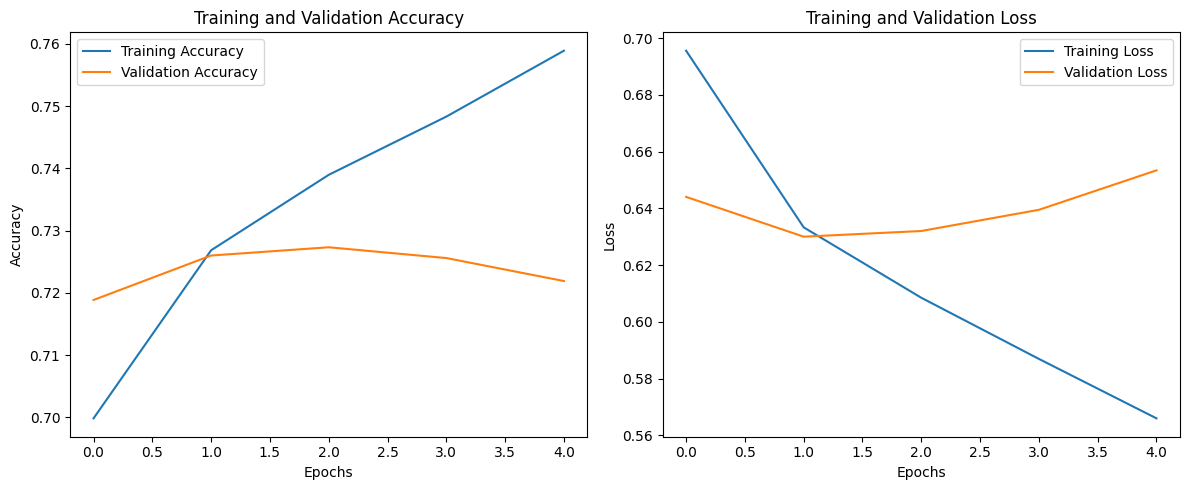

In [ ]:


# Load training history
history_path = 'rnn_lstm_history.json'
with open(history_path, 'r') as f:
    saved_history = json.load(f)

# Extract accuracy and loss data
train_accuracy = saved_history.get('accuracy', [])
val_accuracy = saved_history.get('val_accuracy', [])
train_loss = saved_history.get('loss', [])
val_loss = saved_history.get('val_loss', [])

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


- The training accuracy steadily increases over the epochs, indicating that the model is learning and fitting well on the training data.
- Validation accuracy improves initially but then plateaus around 0.726–0.727 and even slightly decreases after the third epoch.
> This suggests that while the model is learning patterns in the training data, it may not be generalizing as well to the validation data after a certain point. This behavior is often a sign of early overfitting.

- The training loss consistently decreases across epochs, which aligns with the increasing training accuracy.
- The validation loss initially decreases but starts to increase after the third epoch. This divergence between training and validation loss is a classic indicator of overfitting, where the model is starting to memorize the training data rather than learning generalizable features.

### This model achieves moderate success, with validation and test accuracy around 0.72. However, overfitting is clear, particularly after epoch 3.









